# Example patient population and pathway timings

This notebook creates the patient population that is used for combining cohorts of patients with different stroke types and treatment(s) given. 

## Aims

Create a list of the patient populations and save the results to file for future use.

The patient population is informed by the SSNAP data used in SAMueL-1 and includes proportions of each of these cohorts:
+ haemorrhagic
+ nLVO with no treatment
+ nLVO with IVT
+ LVO with no treatment
+ LVO with IVT only
+ LVO with MT only
+ LVO with both IVT and MT


## Methods

__Patients:__ The patient population is built using the statistics from the SSNAP data used in SAMueL-1 for patients who arrive at hospital within six hours of stroke onset:
+ [Breakdown of patients into haemorrhagic / NIHSS 0 to 10 / NIHSS 11 and higher](https://samuel-book.github.io/samuel-1/descriptive_stats/10_using_nihss_10_for_lvo.html)
+ [Breakdown of proportion of thrombolysed patients by NIHSS score](https://samuel-book.github.io/samuel-1/descriptive_stats/01a_descriptive_nihss_cutoff.html)

We use the NIHSS score to decide whether patients had an LVO or an nLVO. When NIHSS is 11 or higher, we assign LVO. When NIHSS is 10 or under, we assign nLVO.

We combine these statistics with targets for how many patients should receive treatment:
+ 18% of all patients should receive IVT
+ 5% of all patients should receive MT
+ 85% of patients who receive MT should have previously received IVT

We can then define a proportion of the population who has each stroke type and each treatment and adjust the proportions to match the existing statistics and the treatment rate targets.

## Notebook setup

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os

from numpy import isclose  # for checking proportions vs targets

Save output files to this directory:

In [2]:
dir_output = 'data'
dir_images = 'images'

Use the following colours in the pie charts:

In [3]:
colour_dict = {
    'haemorrhagic': 'grey',
    'lvo': '#0072b2',                # seaborn colorblind blue
    'nlvo': '#d55e00',               # seaborn colorblind orange
    'lvo_no_treatment': '#00517f',   # seaborn colorblind blue darker
    'lvo_ivt_only': '#0072b2',       # seaborn colorblind blue
    'lvo_ivt_mt': '#0093e5',         # seaborn colorblind blue lighter
    'lvo_mt_only': '#00b3ff',        # seaborn colorblind blue lighter 2
    'nlvo_no_treatment': '#d55e00',  # seaborn colorblind orange
    'nlvo_ivt': '#ff7400',           # seaborn colorblind orange lighter
}

## Stroke types

For patients arriving within 6 hours of stroke onset (from [SAMueL-1 book](https://samuel-book.github.io/samuel-1/descriptive_stats/10_using_nihss_10_for_lvo.html)):
+ 13.6% have haemorrhagic stroke
+ The remaining strokes are ischaemic. Of these:
  + 29.5% are LVO
  + 70.5% are nLVO

In [4]:
stroke_type_proportions = {
    'haemorrhagic': 0.136,
    'lvo': 0.295 * (1 - 0.136),
    'nlvo': 0.705 * (1 - 0.136)
}

Display the proportions:

In [5]:
pd.Series(stroke_type_proportions)

haemorrhagic    0.13600
lvo             0.25488
nlvo            0.60912
dtype: float64

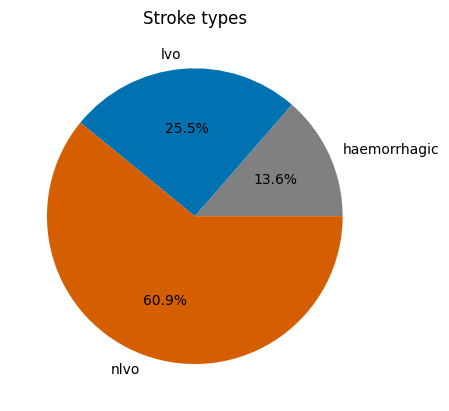

In [6]:
plt.pie(
    stroke_type_proportions.values(),
    labels=stroke_type_proportions.keys(),
    autopct='%1.1f%%',
    colors=[colour_dict[c] for c in stroke_type_proportions.keys()]
    )
plt.title('Stroke types')
plt.savefig(os.path.join(dir_images, 'props_stroke_types.png'), bbox_inches='tight')
plt.show()

# Target treatment rates

## Treatment

Fix the MT value first because this depends only on LVO.

Patients with NIHSS>10 account for 46.7% of all thrombolysed patients ([from SAMueL-1](https://samuel-book.github.io/samuel-1/descriptive_stats/01a_descriptive_nihss_cutoff.html)).

Multiply this proportion by the target IVT rate:

> 18% $\times$ 46.7% = Proportion of all patients with LVO and IVT

And assign the remaining patients to nLVO:

> 18% $\times$ (100% - 46.7%) = Proportion of all patients with nLVO and IVT

Then account for the fact that most LVO patients receiving MT also receive IVT.

In [7]:
target_ivt = 0.18
target_mt = 0.05
prop_mt_previously_ivt = 0.85

prop_ivt_lvo = 0.467

### nLVO

In [8]:
prop_nlvo_ivt = target_ivt * (1.0 - prop_ivt_lvo) / stroke_type_proportions['nlvo']

Display the proportions:

In [9]:
nlvo_proportions = {
    'nlvo_no_treatment': (1.0 - prop_nlvo_ivt),
    'nlvo_ivt': prop_nlvo_ivt,
}

In [10]:
pd.Series(nlvo_proportions)

nlvo_no_treatment    0.842494
nlvo_ivt             0.157506
dtype: float64

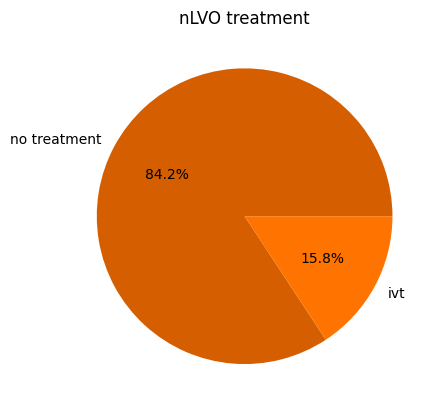

In [11]:
plt.pie(
    nlvo_proportions.values(),
    labels=[c.split('nlvo_')[1].replace('_', ' ') for c in nlvo_proportions.keys()],
    autopct='%1.1f%%',
    colors=[colour_dict[c] for c in nlvo_proportions.keys()]
    )
plt.title('nLVO treatment')
plt.savefig(os.path.join(dir_images, 'props_nlvo.png'), bbox_inches='tight')
plt.show()

### LVO

Only LVO is treated with MT, so to hit the target value of 10% we need:

> Proportion LVO $\times$ Proportion of LVO treated with MT = 10%

Rearranging:

> Proportion of LVO treated with MT = 10% / Proportion LVO

In [12]:
prop_lvo_mt = target_mt / stroke_type_proportions['lvo']

Then set the overlap between IVT and MT for LVO patients:

In [13]:
prop_lvo_ivtmt = prop_lvo_mt * prop_mt_previously_ivt

Find the LVO patients treated with IVT:

In [14]:
prop_lvo_ivt = (target_ivt * prop_ivt_lvo) / stroke_type_proportions['lvo']

Compare values:

In [15]:
print(prop_lvo_mt, prop_lvo_ivtmt, prop_lvo_ivt)

0.19617074701820467 0.16674513496547397 0.3298022598870056


Subtract the overlap:

In [16]:
prop_lvo_mtonly = prop_lvo_mt - prop_lvo_ivtmt
prop_lvo_ivtonly = prop_lvo_ivt - prop_lvo_ivtmt

Display the LVO proportions:

In [17]:
lvo_proportions = {
    'lvo_no_treatment': (1.0 - prop_lvo_mt - prop_lvo_ivtonly),
    'lvo_ivt_only': prop_lvo_ivtonly,
    'lvo_ivt_mt': prop_lvo_ivtmt,
    'lvo_mt_only': prop_lvo_mtonly,
}

In [18]:
pd.Series(lvo_proportions)

lvo_no_treatment    0.640772
lvo_ivt_only        0.163057
lvo_ivt_mt          0.166745
lvo_mt_only         0.029426
dtype: float64

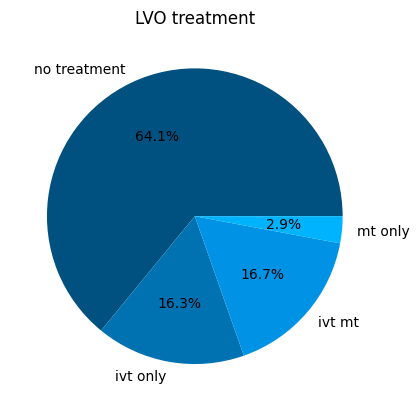

In [19]:
plt.pie(
    lvo_proportions.values(),
    labels=[c.split('lvo_')[1].replace('_', ' ') for c in lvo_proportions.keys()],
    autopct='%1.1f%%',
    colors=[colour_dict[c] for c in lvo_proportions.keys()]
    )
plt.title('LVO treatment')
plt.savefig(os.path.join(dir_images, 'props_lvo.png'), bbox_inches='tight')
plt.show()

## Whole population breakdown

In [20]:
pop_proportions = {
    'haemorrhagic': stroke_type_proportions['haemorrhagic'],
    'lvo_no_treatment': stroke_type_proportions['lvo'] * lvo_proportions['lvo_no_treatment'],
    'lvo_ivt_only': stroke_type_proportions['lvo'] * lvo_proportions['lvo_ivt_only'],
    'lvo_ivt_mt': stroke_type_proportions['lvo'] * lvo_proportions['lvo_ivt_mt'],
    'lvo_mt_only': stroke_type_proportions['lvo'] * lvo_proportions['lvo_mt_only'],
    'nlvo_no_treatment': stroke_type_proportions['nlvo'] * nlvo_proportions['nlvo_no_treatment'],
    'nlvo_ivt': stroke_type_proportions['nlvo'] * nlvo_proportions['nlvo_ivt'],
}

# Round values to 5 decimal places:
for key, value in pop_proportions.items():
    pop_proportions[key] = round(value, 5)

In [21]:
pd.Series(pop_proportions)

haemorrhagic         0.13600
lvo_no_treatment     0.16332
lvo_ivt_only         0.04156
lvo_ivt_mt           0.04250
lvo_mt_only          0.00750
nlvo_no_treatment    0.51318
nlvo_ivt             0.09594
dtype: float64

### Sanity checks

Do all proportions add up to 1?

In [22]:
pd.Series(pop_proportions).sum()

1.0

Check that the treated proportions match the targets:

In [23]:
prop_ivt = 0.0
prop_mt = 0.0

for key, value in pop_proportions.items():
    if 'ivt' in key:
        prop_ivt += value
    if 'mt' in key:
        prop_mt += value

In [24]:
print('IVT:', prop_ivt, isclose(prop_ivt, target_ivt))
print('MT:', prop_mt, isclose(prop_mt, target_mt))

IVT: 0.18 True
MT: 0.05 True


Check that the stroke type subgroups add up to the total stroke type sizes:

In [25]:
prop_lvo = 0.0
prop_nlvo = 0.0

for key, value in pop_proportions.items():
    if 'nlvo' in key:
        prop_nlvo += value
    elif 'lvo' in key:
        prop_lvo += value

In [26]:
print('LVO:', prop_lvo, isclose(prop_lvo, stroke_type_proportions['lvo']))
print('nLVO:', prop_nlvo, isclose(prop_nlvo, stroke_type_proportions['nlvo']))

LVO: 0.25488 True
nLVO: 0.60912 True


### Plot

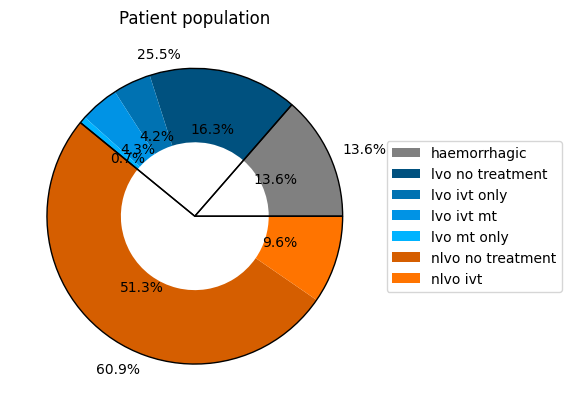

In [27]:
fig, ax = plt.subplots()

# Draw each cohort/treatment subgroup in a different colour
# and write the size on the wedge.
wedges, texts, autotexts = ax.pie(
    pop_proportions.values(),
    autopct='%1.1f%%',
    radius=1.0,
    wedgeprops=dict(width=0.5),
    colors=[colour_dict[c] for c in pop_proportions.keys()]
    )

# Outline LVO, nLVO and haemorrhagic sections
# and add labels outside each section.
ax.pie(
    stroke_type_proportions.values(),
    labels=[f'{c:.1%}' for c in stroke_type_proportions.values()],
    # autopct='%1.1f%%',
    radius=1.0,
    wedgeprops=dict(width=1.0, edgecolor='k'),
    colors=['None'] * len(stroke_type_proportions),
    )

ax.legend(
    wedges, [c.replace('_', ' ') for c in pop_proportions.keys()],
    bbox_to_anchor=[1.0, 0.5], loc='center left'
)

plt.title('Patient population')
plt.savefig(os.path.join(dir_images, 'props_all.png'), bbox_inches='tight')
plt.show()

### Save population proportions to file

In [28]:
pd.Series(pop_proportions).to_csv(os.path.join(dir_output, 'patient_proportions_target.csv'), header=False)

## Exclude haemorrhagic stroke

In [29]:
pop_ischaemic = dict()
prop_ischaemic = 1.0 - pop_proportions['haemorrhagic']

for key, value in pop_proportions.items():
    if 'haemo' not in key:
        pop_ischaemic[key] = value / prop_ischaemic

In [30]:
pd.Series(pop_ischaemic)

lvo_no_treatment     0.189028
lvo_ivt_only         0.048102
lvo_ivt_mt           0.049190
lvo_mt_only          0.008681
nlvo_no_treatment    0.593958
nlvo_ivt             0.111042
dtype: float64

In [31]:
pd.Series(pop_ischaemic).sum()

1.0

In [32]:
ischaemic_proportions = dict()

for key, value in stroke_type_proportions.items():
    if 'haemo' not in key:
        ischaemic_proportions[key] = value / prop_ischaemic

In [33]:
pd.Series(ischaemic_proportions)

lvo     0.295
nlvo    0.705
dtype: float64

In [34]:
pd.Series(ischaemic_proportions).sum()

1.0

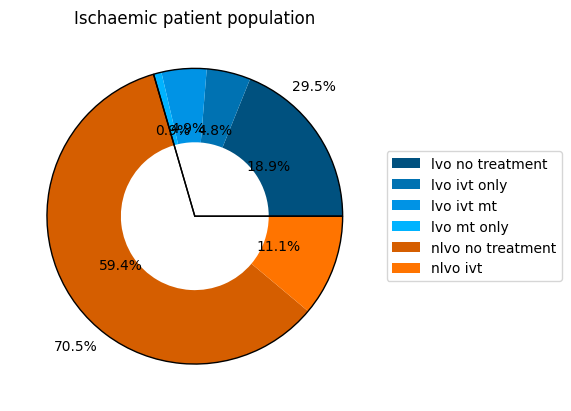

In [35]:
fig, ax = plt.subplots()

# Draw each cohort/treatment subgroup in a different colour
# and write the size on the wedge.
wedges, texts, autotexts = ax.pie(
    pop_ischaemic.values(),
    autopct='%1.1f%%',
    radius=1.0,
    wedgeprops=dict(width=0.5),
    colors=[colour_dict[c] for c in pop_ischaemic.keys()]
    )

# Outline LVO, nLVO and haemorrhagic sections
# and add labels outside each section.
ax.pie(
    ischaemic_proportions.values(),
    labels=[f'{c:.1%}' for c in ischaemic_proportions.values()],
    # autopct='%1.1f%%',
    radius=1.0,
    wedgeprops=dict(width=1.0, edgecolor='k'),
    colors=['None'] * len(ischaemic_proportions),
    )

ax.legend(
    wedges, [c.replace('_', ' ') for c in pop_ischaemic.keys()],
    bbox_to_anchor=[1.0, 0.5], loc='center left'
)

plt.title('Ischaemic patient population')
plt.savefig(os.path.join(dir_images, 'props_ischaemic.png'), bbox_inches='tight')
plt.show()

# Actual treatment rates

Repeat the above analysis with a different IVT rate for each stroke unit.

## Data gathering

Actual treatment rates by stroke team

+ Sentinel Stroke National Audit Programme (SSNAP) Clinical Audit Report: "SSNAP Annual Portfolio for April 2023-March 2024 admissions and discharges"
+ Column April 2023 - March 2024
+ Data section "3.1 Percentage of all stroke patients given thrombolysis (all stroke types)", row "3.1B Team centred Item reference: H16.3"

In [36]:
postcode_dict = {
    'Royal Victoria Hospital Belfast': 'BT126BA',
    'Antrim Area Hospital': 'BT412RL',
    'Causeway Hospital': 'BT521HS',
    'Ulster Hospital': 'BT161RH',
    'Craigavon Area Hospital': 'BT635QQ',
    'Daisy Hill Hospital': 'BT358DR',
    'Altnagelvin Hospital': 'BT476SB',
    'South West Acute Hospital': 'BT746DN'
}

In [37]:
actual_ivt_rates = {
    'Royal Victoria Hospital Belfast': 0.164,
    'Antrim Area Hospital': 0.112,
    'Causeway Hospital': 0.115,
    'Ulster Hospital': 0.165,
    'Craigavon Area Hospital': 0.113,
    'Daisy Hill Hospital': 0.151,
    'Altnagelvin Hospital': 0.104,
    'South West Acute Hospital': 0.119
}

+ 8,764 strokes in August 2020 - July 2023 inclusive (over three years)
+ Data section "Thrombectomy": 153 thrombectomies (over one year)

In [38]:
actual_mt_rate = round(153.0 / (8764.0 / 3.0), 5)

actual_mt_rate

0.05237

+ Data section "Thrombolysis if received thrombectomy", item "Also received thrombolysis"

In [39]:
actual_mt_also_received_ivt = 0.379

Use the same proportions as defined earlier for:
+ proportion nLVO (`stroke_type_proportions['nlvo']`)
+ proportion LVO (`stroke_type_proportions['lvo']`)
+ proportion haemorrhagic (`stroke_type_proportions['haemorrhagic']`)
+ proportion of patients given IVT who had LVO (`prop_ivt_lvo`)

### Calculate proportions

Follow the same method as earlier but condensed into this one function:

In [40]:
def calculate_patient_proportions(
        unit_name,
        actual_ivt_rate,
        actual_mt_rate,
        actual_mt_also_received_ivt,
        prop_nlvo,
        prop_lvo,
        prop_haemo,
        prop_ivt_lvo,
    ):
    # nLVO
    prop_nlvo_ivt = actual_ivt_rate * (1.0 - prop_ivt_lvo) / prop_nlvo
    # LVO
    prop_lvo_mt = actual_mt_rate / prop_lvo
    prop_lvo_ivtmt = prop_lvo_mt * actual_mt_also_received_ivt
    prop_lvo_ivt = (actual_ivt_rate * prop_ivt_lvo) / prop_lvo
    # Subract the overlap:
    prop_lvo_mtonly = prop_lvo_mt - prop_lvo_ivtmt
    prop_lvo_ivtonly = prop_lvo_ivt - prop_lvo_ivtmt

    # Whole population:
    pop_proportions = {
        'haemorrhagic': prop_haemo,
        'lvo_no_treatment': prop_lvo * (1.0 - (prop_lvo_ivtonly + prop_lvo_mtonly + prop_lvo_ivtmt)),
        'lvo_ivt_only': prop_lvo * prop_lvo_ivtonly,
        'lvo_ivt_mt': prop_lvo * prop_lvo_ivtmt,
        'lvo_mt_only': prop_lvo * prop_lvo_mtonly,
        'nlvo_no_treatment': prop_nlvo * (1.0 - prop_nlvo_ivt),
        'nlvo_ivt': prop_nlvo * prop_nlvo_ivt,
    }
    # Round values to 5 decimal places:
    for key, value in pop_proportions.items():
        pop_proportions[key] = round(value, 5)
    return pop_proportions

In [41]:
def sanity_checks(
        unit_name,
        pop_proportions,
        actual_ivt_rate,
        actual_mt_rate,
        target_prop_lvo,
        target_prop_nlvo
    ):
    if not isclose(pd.Series(pop_proportions).sum(), 1.0):
        print(f'{unit_name}: Sum is not 1.')
        print(f'    Sum: {pd.Series(pop_proportions).sum()}')
        
    prop_ivt = 0.0
    prop_mt = 0.0

    for key, value in pop_proportions.items():
        if 'ivt' in key:
            prop_ivt += value
        if 'mt' in key:
            prop_mt += value

    if not isclose(prop_ivt, actual_ivt_rate):
        print(f'{unit_name}: IVT rate does not match target.')
        print(f'    Rate:   {prop_ivt}')
        print(f'    Target: {actual_ivt_rate}')
    if not isclose(prop_mt, actual_mt_rate):
        print(f'{unit_name}: MT rate does not match target.')
        print(f'    Rate:   {prop_mt}')
        print(f'    Target: {actual_mt_rate}')

    prop_lvo = 0.0
    prop_nlvo = 0.0
    
    for key, value in pop_proportions.items():
        if 'nlvo' in key:
            prop_nlvo += value
        elif 'lvo' in key:
            prop_lvo += value
    
    if not isclose(prop_lvo, target_prop_lvo):
        print(f'{unit_name}: LVO proportion does not match target.')
        print(f'    Rate:   {prop_lvo}')
        print(f'    Target: {target_prop_lvo}')
    if not isclose(prop_nlvo, target_prop_nlvo):
        print(f'{unit_name}: nLVO proportion does not match target.')
        print(f'    Rate:   {prop_nlvo}')
        print(f'    Target: {target_prop_nlvo}')

In [42]:
def plot_patient_proportions(
        pop_proportions,
        stroke_type_proportions,
        colour_dict,
        savename='',
        title=''
    ):
    fig, ax = plt.subplots()

    # Draw each cohort/treatment subgroup in a different colour
    # and write the size on the wedge.
    wedges, texts, autotexts = ax.pie(
        pop_proportions.values(),
        autopct='%1.1f%%',
        radius=1.0,
        wedgeprops=dict(width=0.5),
        colors=[colour_dict[c] for c in pop_proportions.keys()]
        )
    
    # Outline LVO, nLVO and haemorrhagic sections
    # and add labels outside each section.
    ax.pie(
        stroke_type_proportions.values(),
        labels=[f'{c:.1%}' for c in stroke_type_proportions.values()],
        # autopct='%1.1f%%',
        radius=1.0,
        wedgeprops=dict(width=1.0, edgecolor='k'),
        colors=['None'] * len(stroke_type_proportions),
        )
    
    ax.legend(
        wedges, [c.replace('_', ' ') for c in pop_proportions.keys()],
        bbox_to_anchor=[1.0, 0.5], loc='center left'
    )
    
    plt.title(title)
    if len(savename) > 0:
        plt.savefig(savename, bbox_inches='tight')
    plt.show()

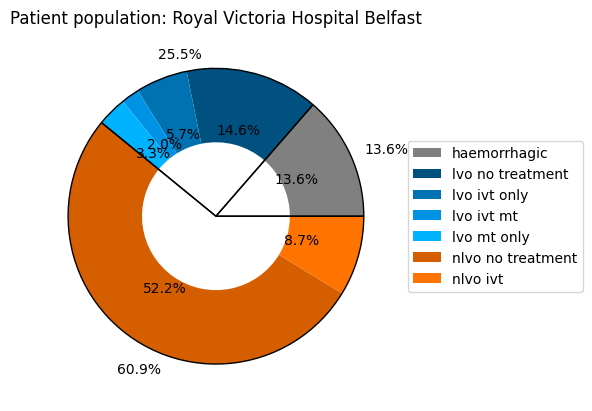

Antrim Area Hospital: IVT rate does not match target.
    Rate:   0.11201
    Target: 0.112


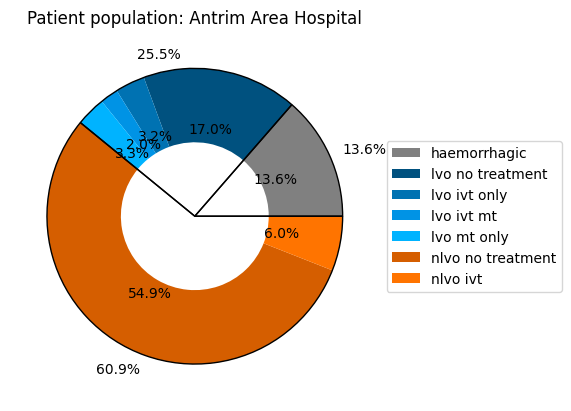

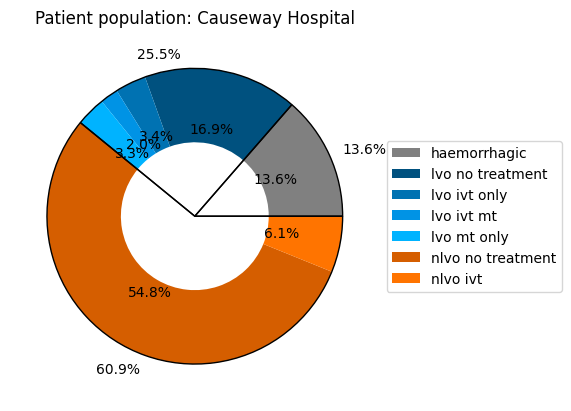

Ulster Hospital: nLVO proportion does not match target.
    Rate:   0.60911
    Target: 0.60912


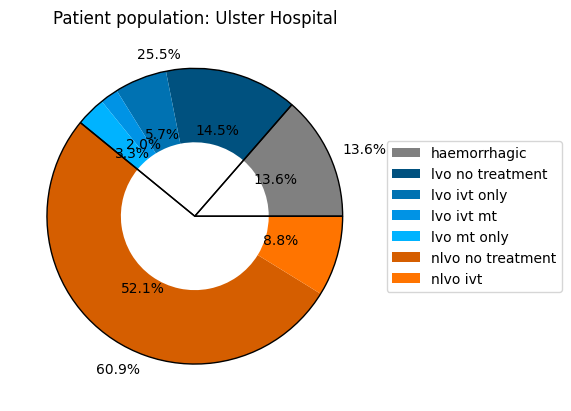

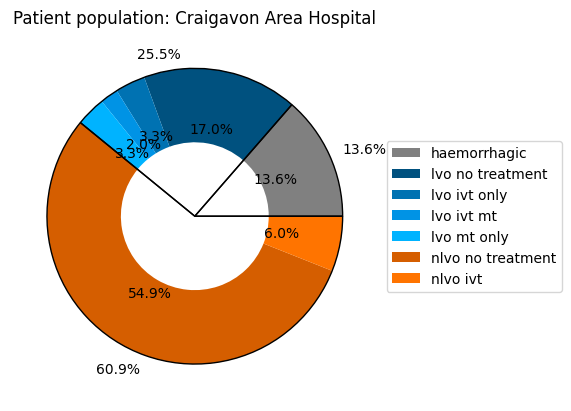

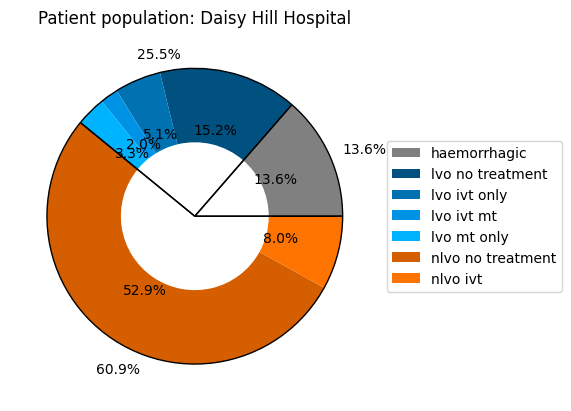

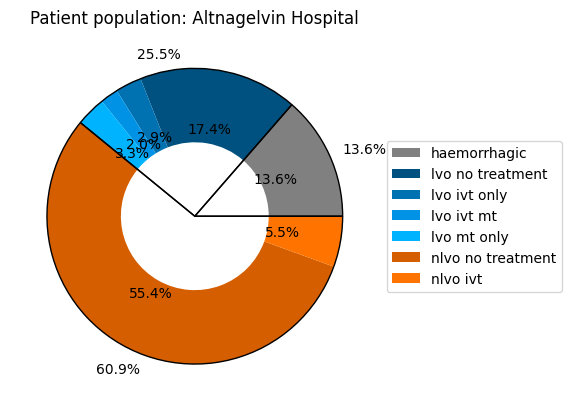

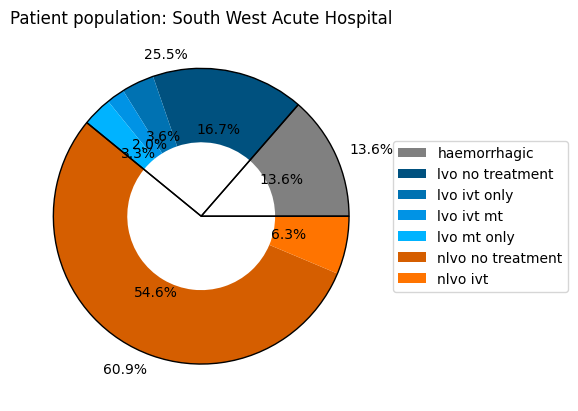

In [44]:
for unit_name, actual_ivt_rate in actual_ivt_rates.items():
    unit_postcode = postcode_dict[unit_name]
    
    pop_proportions = calculate_patient_proportions(
        unit_name,
        actual_ivt_rate,
        actual_mt_rate,
        actual_mt_also_received_ivt,
        stroke_type_proportions['nlvo'],
        stroke_type_proportions['lvo'],
        stroke_type_proportions['haemorrhagic'],
        prop_ivt_lvo,
    )
    
    sanity_checks(
        unit_name,
        pop_proportions,
        actual_ivt_rate,
        actual_mt_rate,
        stroke_type_proportions['lvo'],
        stroke_type_proportions['nlvo'],
    )
    
    title = f'Patient population: {unit_name}'
    savename=os.path.join(dir_images, f'props_all_{unit_postcode}.png')
    plot_patient_proportions(
        pop_proportions,
        stroke_type_proportions,
        colour_dict,
        savename,
        title
    )

    # Save to file:
    pd.Series(pop_proportions).to_csv(os.path.join(dir_output, f'patient_proportions_{unit_postcode}.csv'), header=False)

## Conclusion

The data in the pathway times dictionary and in the patient proportions dictionary for the full population including haemorrhagic stroke have been saved to file and can now be used across multiple projects.

The final patient proportions are in this pie chart:

![Pie chart of the stroke type and treatment proportions.](images/props_all.png)